In [1]:
import numpy as np
import pandas as pd
import os
from scipy.stats import ks_2samp

In [2]:
import keras as K
import keras
from keras.layers import *
from keras.models import *
from keras.callbacks import *

/home/deeplearning/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn.model_selection import KFold

In [4]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [5]:
arch = ["cnn", "capsule"]
text = ["default", "norm", "stem"]
embed = ["fasttext", "selftrain_300", "selftrain_100"]

In [6]:
all_models = []
test_results = []

In [19]:
for a in arch:
    for t in text:
        for e in embed:
            model_dict = {}
            model_name = f"{a}_{t}_{e}"
            model_dict["name"] = model_name
            try:
                test_csv = pd.read_csv(f"./checkpoint/{model_name}/{model_name}_preds_test.csv")
                model_dict["test_csv"] = test_csv
                test_results.append(test_csv["deal_probability"].values)
            except:
                print("[+] There is no test result")
                model_dict["test_csv"] = None
            
            try:
                preds_train = np.load(f"./checkpoint/{model_name}/{model_name}_train_pred.npy")
                preds_train_csv = pd.DataFrame(preds_train, columns=["deal_probability"])
                model_dict["train_preds"] = preds_train_csv
            except:
                print("[+] There is no train result")
                model_dict["train_preds"] = None
            all_models.append(model_dict)

In [7]:
def avg_test_result():
    test_results = np.array(test_results)
    test_results = np.mean(test_results, axis=0)
    test_csv["deal_probability"] = test_results
    test_csv.head(5)
    test_csv.to_csv("18_NN_avg.csv", index=False)

In [8]:
def get_correlation():
    class_name="deal_probability"
    for i in range(len(all_models)-1):
        model_i = all_models[i]
        name_i = model_i["name"]
        for j in range(i+1, len(all_models)):
            model_j = all_models[j]
            name_j = model_j["name"]
            print(f"\n Correlation between {name_i} and {name_j}")
            print(" \n***** Train prediction *****")
            if model_i["train_preds"] is not None and model_j["train_preds"] is not None:
                print(' Pearson\'s correlation score: %0.6f' %
                      model_i["train_preds"][class_name].corr(
                          model_j["train_preds"][class_name], method='pearson'))
                print(' Kendall\'s correlation score: %0.6f' %
                      model_i["train_preds"][class_name].corr(
                          model_j["train_preds"][class_name], method='kendall'))
                print(' Spearman\'s correlation score: %0.6f' %
                      model_i["train_preds"][class_name].corr(
                          model_j["train_preds"][class_name], method='spearman'))
                ks_stat, p_value = ks_2samp(model_i["train_preds"][class_name].values,
                                            model_j["train_preds"][class_name].values)
                print(' Kolmogorov-Smirnov test:    KS-stat = %.6f    p-value = %.3e\n'
                      % (ks_stat, p_value))
            else:
                print(" None\n")

            print(" ***** Test prediction *****")
            if model_i["test_csv"] is not None and model_j["test_csv"] is not None:
                print(' Pearson\'s correlation score: %0.6f' %
                      model_i["test_csv"][class_name].corr(
                          model_j["test_csv"][class_name], method='pearson'))
                print(' Kendall\'s correlation score: %0.6f' %
                      model_i["test_csv"][class_name].corr(
                          model_j["test_csv"][class_name], method='kendall'))
                print(' Spearman\'s correlation score: %0.6f' %
                      model_i["test_csv"][class_name].corr(
                          model_j["test_csv"][class_name], method='spearman'))
                ks_stat, p_value = ks_2samp(model_i["test_csv"][class_name].values,
                                            model_j["test_csv"][class_name].values)
                print(' Kolmogorov-Smirnov test:    KS-stat = %.6f    p-value = %.3e\n'
                      % (ks_stat, p_value))
            else:
                print(" None\n")

In [9]:
def make_features():
    X = []
    test = []
    for model in all_models:
        X.append(model["train_preds"]["deal_probability"].values)
        test.append(model["test_csv"]["deal_probability"].values)
    return np.array(X), np.array(test)

In [ ]:
def get_stack_model(n_features, model="mlp"):
    if model == "mlp":
        in_features = Input(shape=(n_features, ))
        x = Dense(256, activation="linear")(in_features)
        x = Dense(64, activation="linear")(in_features)
        x = Dense(1, activation="sigmoid")(x)
        
        m = Model(inputs=in_features, outputs=x)
        m.compile(optimizer=optimizers.Adam(lr=0.001), loss="mean_squared_error", metrics=[rmse])
    elif model == "dnn":
        in_features = Input(shape=(n_features, 1, ))
        x = Conv1D(filters=8, kernel_size=3)(in_features)
        x = Conv1D(filters=16, kernel_size=3)(x)
        x = Conv1D(filters=32, kernel_size=3)(x)
        x = Flatten()(x)
        x = Dense(32)(x)
        x = Dense(1, activation="sigmoid")(x)
        
        m = Model(inputs=in_features, outputs=x)
        m.compile(optimizer=optimizers.Adam(lr=0.001), loss="mean_squared_error", metrics=[rmse])
    return m

In [20]:
X, test = make_features()
y = np.load("./features/default/y_train.npy")
X = X.T
test = test.T

In [ ]:
# For DNN method only
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
test = np.reshape(test, (test.shape[0], test.shape[1], 1))

array([], dtype=float64)

In [11]:
stack_folder = "stack_folder"
if not os.path.exists(stack_folder):
    os.mkdir(stack_folder)

In [ ]:
k=5
kf = KFold(5, shuffle=True, random_state=2018)

test_preds_all = []
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"[+] Fold {fold}")
    
    model = get_stack_model(X.shape[1], model="dnn")
    model.summary()
    
    file_path = f"{stack_folder}/stack_model_{fold}.h5"
    checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=2, save_best_only=True,
                                 save_weights_only=True,
                                 mode='min')
    early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
    lr_reduced = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=2,
                               verbose=1,
                               epsilon=1e-4,
                               min_lr=1e-5,
                               mode='min')
    callbacks_list = [early, checkpoint, lr_reduced]
    
    X_train = X[train_index]
    y_train = y[train_index]
    
    X_val = X[val_index]
    y_val = y[val_index]
    
    model.fit(X_train, y_train, 
              validation_data=(X_val, y_val),
              verbose=1,
              callbacks=callbacks_list,
              epochs=100, batch_size=1024)
    
    model.load_weights(file_path)
    test_preds = model.predict(test, batch_size=1024)
    test_preds_all.append(test_preds)

In [ ]:
test_preds = np.array(test_preds_all)
test_preds_mean = np.mean(test_preds, axis=0)

In [ ]:
test_csv["deal_probability"] = test_preds_mean

In [ ]:
test_csv.head(5)

In [ ]:
test_csv.to_csv("18_NN_Stack_NN.csv", index=False)

In [ ]:
test_avg = pd.read_csv("18_NN_avg.csv")

In [ ]:
print(' Pearson\'s correlation score: %0.6f' %
      test_csv["deal_probability"].corr(
          test_avg["deal_probability"], method='pearson'))

In [14]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [13]:
lgbm_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 15,
    'num_leaves': 35,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'learning_rate': 0.019,
    'verbose': 0
}

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

# LGBM Dataset Formatting
lgtrain = lgb.Dataset(X_train, y_train)
lgvalid = lgb.Dataset(X_valid, y_valid)

In [23]:
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=15000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train', 'valid'],
    early_stopping_rounds=200,
    verbose_eval=200
)

Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 0.206358	valid's rmse: 0.207005
[400]	train's rmse: 0.205365	valid's rmse: 0.206401
[600]	train's rmse: 0.204854	valid's rmse: 0.206266
[800]	train's rmse: 0.204432	valid's rmse: 0.206206
[1000]	train's rmse: 0.204065	valid's rmse: 0.206168
[1200]	train's rmse: 0.20371	valid's rmse: 0.206144
[1400]	train's rmse: 0.203383	valid's rmse: 0.206131
[1600]	train's rmse: 0.203062	valid's rmse: 0.206123
[1800]	train's rmse: 0.20276	valid's rmse: 0.206115
[2000]	train's rmse: 0.202462	valid's rmse: 0.206114
[2200]	train's rmse: 0.202181	valid's rmse: 0.206114
Early stopping, best iteration is:
[2106]	train's rmse: 0.20231	valid's rmse: 0.206111


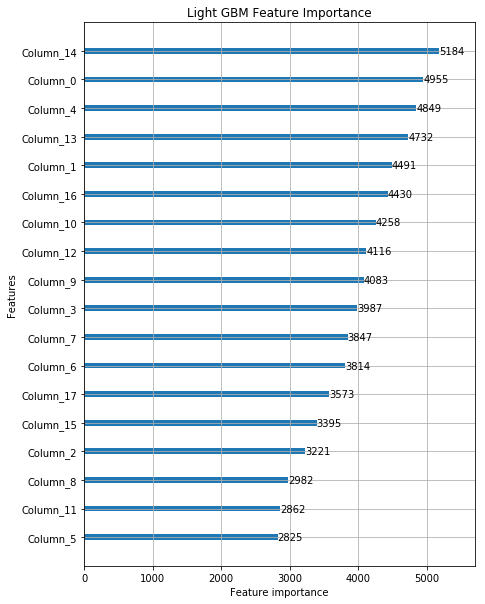

In [26]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=[7, 10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig(f'feature_import_fold.png')

In [28]:
lgpred = lgb_clf.predict(test)
sample_csv = pd.read_csv("18_NN_avg.csv")
sample_csv["deal_probability"] = lgpred

In [29]:
NN_avg = pd.read_csv("18_NN_avg.csv")

In [30]:
print(' Pearson\'s correlation score: %0.6f' %
      sample_csv["deal_probability"].corr(
          NN_avg["deal_probability"], method='pearson'))

 Pearson's correlation score: 0.952854


In [31]:
sample_csv.head(5)

,item_id,deal_probability
0,6544e41a8817,0.183116
1,65b9484d670f,0.140310
2,8bab230b2ecd,0.166635
3,8e348601fefc,0.104253
4,8bd2fe400b89,0.132897


In [32]:
sample_csv['deal_probability'].clip(0.0, 1.0, inplace=True)

In [33]:
sample_csv.to_csv(f"18_NN_tree.csv", index=False)